In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
np.NaN=np.nan
import pandas_ta as ta
import importlib
from typing import Tuple
import vectorbt as vbt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tqdm
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
import pandas as pd

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 
pd.set_option('display.max_colwidth', None)

##### These variables can be changed


In [4]:
#General variables
START_DATE = "2017-01-01"
TRADING_START_DATE = "2018-01-01"
END_DATE = "2024-01-01"                 #datetime.today().strftime('%Y-%m-%d')
UNIVERSE_NAME         = "All Cap"

# Zscore generation
ROLLING_THRESHOLD     = -99999
ROLLING_PERIOD        = 16
MEAN_PERIOD           = 28

# Weights Generation
Z_MEAN                = True
FREQUENCY             = "monthly"      # "weekly" or "monthly"
INITIAL_CAPITAL       = 100000
NUM_STOCKS_ACTIVE     = 30
ZSCORE_THRESHOLD      = 0.1
ZSCORE_PERIOD         = 24

DILUTE_TO = 15


##### These variables cannot be changed


In [5]:
INTERVALS = 'data/nifty500/nifty500_weekly_ohlcv.csv'

In [6]:
vix_data= pd.read_csv('data/vix_daily_ohlcv copy.csv', header=[0,1], index_col=0, parse_dates=True)# or could have used  skiprows if didnt wanted to use tuple 

In [7]:
open_val = vix_data[("^INDIAVIX", "Open")]
close_val =vix_data[("^INDIAVIX", "Close")]
dates = vix_data.index

def vix_rebalancing_Date(df):
    rebalancing_close = []
    rebalancing_open = []

    # Loop through rows
    for date, row in df.iterrows():
        open_val = row[("^INDIAVIX", "Open")]
        close_val = row[("^INDIAVIX", "Close")]

        # Rising VIX condition
        rising_vix = (open_val < 17) and (((close_val - open_val) / open_val) * 100 > 15)

        # Falling VIX condition
        falling_vix = (open_val > 22) and (((close_val - open_val) / open_val) * 100 < -15)

        # Append dates accordingly
        if rising_vix:
            rebalancing_open.append(date)
        elif falling_vix:
            rebalancing_close.append(date)

    return rebalancing_open, rebalancing_close

rebal_rising, rebal_falling = vix_rebalancing_Date(vix_data)

vix_rising = [d for d in rebal_rising if d < pd.Timestamp('2023-12-31 00:00:00')]
vix_falling = [d for d in rebal_falling if d < pd.Timestamp('2023-12-31 00:00:00')]

merged_dates = sorted(vix_rising + vix_falling)

print("Rising VIX Dates:", vix_rising[:15] )
print("Falling VIX Dates:", vix_falling[:5])
print("merged VIX Dates:", merged_dates)

print(len(vix_rising))
print(len(vix_falling))
print(len(merged_dates))

Rising VIX Dates: [Timestamp('2018-02-06 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2021-11-22 00:00:00'), Timestamp('2021-11-26 00:00:00'), Timestamp('2021-12-20 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-03-13 00:00:00')]
Falling VIX Dates: [Timestamp('2019-05-20 00:00:00'), Timestamp('2019-05-23 00:00:00'), Timestamp('2022-02-25 00:00:00')]
merged VIX Dates: [Timestamp('2018-02-06 00:00:00'), Timestamp('2019-05-20 00:00:00'), Timestamp('2019-05-23 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2021-11-22 00:00:00'), Timestamp('2021-11-26 00:00:00'), Timestamp('2021-12-20 00:00:00'), Timestamp('2022-02-25 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-03-13 00:00:00')]
8
3
11


In [8]:

__all__ = [
    "Strategy",
    "record_monthly_weights",
    "get_rebalancing_dates",
    "backtest",
    "Backtester",
    "plot_strategy_vs_benchmark",
]

universe_files = {
    'Small Cap': 'ind_niftysmallcap100list.csv',
    'Large Cap': 'ind_nifty50list.csv',
    'Mid Cap': 'ind_niftymidcap100list.csv',
    'Micro Cap': 'ind_niftymicrocap250_list.csv',
    'All Cap': 'data/nifty500/ind_nifty500list.csv'
    }

def record_monthly_weights(weights_df, current_date,next_date, top_set,total_active_sets):
    """
    On the rebalance date (start of month): weight = 1/N
    On the last trading day of that same month: weight = 0
    """
    if not top_set:
        return

    if total_active_sets: 
        # 1) Compute weight
        w = 1.0 / total_active_sets

        # 2) Assign 1/N on rebalance date
        if current_date in weights_df.index:
            weights_df.loc[current_date, list(top_set)] = w

    else:
        if current_date in weights_df.index:
            weights_df.loc[current_date, list(top_set)] = np.nan

    # 3) Find the last trading day in that month
    #    Filter the index to the same year-month, then take the max date
    month = current_date.month
    year  = current_date.year

    # all dates in daily_index that match this month/year
    mask = (
        (weights_df.index.year  == year) &
        (weights_df.index.month == month)
    )
    month_dates = weights_df.index[mask]
    if month_dates.empty:
        return

    # 4) Assign 0 on that last trading day
    weights_df.loc[next_date, list(top_set)] = 0.0

    
def get_rebalancing_dates(mapping_csv="date_mapping.csv"):
    # Load mapping
    df = pd.read_csv(mapping_csv, parse_dates=["rebalancing_date", "week_start", "week_end"])
    
    # Ensure sorted by Week_End
    df = df.sort_values("week_end").drop_duplicates("week_end")
    
    # Extract first week_end of each month
    monthly_rebalancing = (
        df.groupby([df["week_end"].dt.year, df["week_end"].dt.month])["week_end"].first().sort_values().to_list()
    )
    
    return monthly_rebalancing
    
def backtest(start_date, end_date,z_mean, universe_name, frequency="monthly", 
             initial_capital=100000, number_stocks_active=100, 
             zscore_threshold=0.0,period=48, risk_free_rate=0.04):
    
    # --- 1) Read your daily trading_signals.csv to get the full daily index ---
    # Read with the first column as the index and parse it as dates
    dates = pd.read_csv("nifty500_daily_ohlcv_clipped.csv",index_col=0,parse_dates=True)
    signals_df=pd.read_csv("auxilary/backtester_weights.csv",index_col=0,parse_dates=True)

    # This is your universe of all trading days
    daily_index = dates.index
    daily_index =daily_index[1:]
    daily_index=pd.DatetimeIndex(daily_index)
    # --- 2) Pre-allocate a weights DataFrame with NaNs on that daily index ---
    weights_df = pd.DataFrame(
        data    = np.nan,
        index   = daily_index,
        columns = signals_df.columns  # all tickers in that file
    )

    z_score_period = period
    z_score_file = 'z_scores_mean.csv' if z_mean else 'z_scores.csv'
    
    # Load the universe from the CSV file
    universe_file = universe_files.get(universe_name)
    if not universe_file:
        raise ValueError(f"Invalid universe name: {universe_name}. Choose from {list(universe_files.keys())}")
    
    universe_df = pd.read_csv(universe_file)
    universe = universe_df.iloc[:, 2].tolist()  # Assuming stock symbols are in the third column
    
    # Load stock prices and z-scores
    stock_prices = pd.read_csv('split_ohlcv_data/all_close.csv', parse_dates=['Date'], index_col='Date')
    z_scores = pd.read_csv(z_score_file, parse_dates=['Date'], index_col='Date')

    # Filter valid stocks
    valid_universe = [stock+".NS" for stock in universe if stock+".NS" in stock_prices.columns]

    # Filter data based on date range
    stock_prices = stock_prices.loc[start_date:end_date, valid_universe]
    z_scores = z_scores.loc[start_date:end_date, valid_universe]

    print('Stock prices and Z-scores loaded.')
    
    portfolio_value = initial_capital
    portfolio_history = []
    dates = z_scores.index

    rebalancing_dates = get_rebalancing_dates()
    rebalancing_dates = sorted(rebalancing_dates + vix_rising)
    rebalancing_dates = pd.DatetimeIndex(rebalancing_dates)
    print(f"Rebalancing dates: {rebalancing_dates[-1]}")
    rebalancing_dates = rebalancing_dates[rebalancing_dates >= '2018-04-02']#IF UPDATED DATE. UPDATE DATE IN "zscore_looptest()" function  AND plot function also
    rebalancing_dates = pd.DatetimeIndex(rebalancing_dates)
    
    portfolio_history.append({'date': rebalancing_dates[0], 'value': portfolio_value})
    prev_top_stocks = set()

    # Adjust risk-free rate based on rebalancing frequency
    periods_per_year = 52 if frequency == "weekly" else 12
    risk_free_growth_factor = (1 + risk_free_rate) ** (1 / periods_per_year)
   

    # Load mapping once outside the loop
    date_mapping = pd.read_csv("date_mapping.csv", parse_dates=["week_start", "week_end", "rebalancing_date"])

    for i, current_date in enumerate(rebalancing_dates[:-1]):
        next_date = rebalancing_dates[i + 1]

        if current_date in vix_rising:

            if not prev_top_stocks:
                continue

            current_week_start = date_mapping.loc[date_mapping["rebalancing_date"] == current_date, "week_start"].iloc[0]
            current_week_end = date_mapping.loc[date_mapping["rebalancing_date"] == current_date, "week_end"].iloc[0]
            previous_distinct_week_start = date_mapping.loc[(date_mapping["rebalancing_date"] < current_date) &(date_mapping["week_start"] != current_week_start),"week_start"].iloc[-1]
            print(f"{current_date} --> {previous_distinct_week_start}")

            if(current_date==current_week_end):
                z_date = current_week_start
            else :
                z_date = previous_distinct_week_start
            
            # Ensure z_date exists in z_scores index, otherwise pick closest earlier date
            if z_date not in z_scores.index:
                # Get all available dates before z_date
                earlier_dates = z_scores.index[z_scores.index < z_date]
                if len(earlier_dates) == 0:
                    continue
                z_date = earlier_dates.max()  # pick the latest available date before z_date

            current_z_scores = z_scores.loc[z_date].dropna()
            print(f"{current_date} --> {z_date}")

            prev_scores = current_z_scores[current_z_scores.index.isin(prev_top_stocks)]
            top_stocks = prev_scores.nlargest(DILUTE_TO).index
           
            top_set = set(top_stocks)
            retained_stocks = top_set & prev_top_stocks
            expelled_stocks = prev_top_stocks - top_set
            new_additions = top_set - prev_top_stocks

            print(f"\nDiluting on {current_date}:")
            print(f"Qualified stocks: {list(top_stocks)}")
            print(f"Retained stocks: {list(retained_stocks)}")
            print(f"Expelled stocks: {list(expelled_stocks)}")
            print(f"New additions: {list(new_additions)}")

            prev_top_stocks = top_set
            record_monthly_weights(weights_df, current_date, next_date, top_set,0)


        else:    
            current_week_start = date_mapping.loc[date_mapping["rebalancing_date"] == current_date, "week_start"].iloc[0]
            current_week_end = date_mapping.loc[date_mapping["rebalancing_date"] == current_date, "week_end"].iloc[0]
            previous_distinct_week_start = date_mapping.loc[(date_mapping["rebalancing_date"] < current_date) &(date_mapping["week_start"] != current_week_start),"week_start"].iloc[-1]
            print(f"{current_date} --> {previous_distinct_week_start}")
            if(current_date==current_week_end) :
                z_date= current_week_start
            
            else :
                z_date= previous_distinct_week_start
            
            current_z_scores = z_scores.loc[z_date].dropna()
            print(f"{current_date} --> {z_date}")
            # Select stocks above the threshold
            top_stocks = current_z_scores[current_z_scores >= zscore_threshold].nlargest(number_stocks_active).index
            
            top_set = set(top_stocks)
            retained_stocks = top_set & prev_top_stocks
            expelled_stocks = prev_top_stocks - top_set
            new_additions = top_set - prev_top_stocks

            print(f"\nRebalancing on {current_date}:")
            print(f"Qualified stocks: {list(top_stocks)}")
            print(f"Retained stocks: {list(retained_stocks)}")
            print(f"Expelled stocks: {list(expelled_stocks)}")
            print(f"New additions: {list(new_additions)}")

            prev_top_stocks = top_set
            record_monthly_weights(weights_df, current_date,next_date, top_set,number_stocks_active)

    # Log the last rebalancing selection (no return calculated)
    rebalancing_dates.normalize()
    final_date = rebalancing_dates[-1]
    
    ### week_start instead of final date in z_score
    final_week_start= date_mapping.loc[date_mapping["rebalancing_date"] == final_date, "week_start"].iloc[0]
    final_z_scores = z_scores.loc[final_week_start].dropna()
    final_top_stocks = final_z_scores[final_z_scores >= zscore_threshold].nlargest(number_stocks_active).index

    final_top_set = set(final_top_stocks)
    final_retained = final_top_set & prev_top_stocks
    final_expelled = prev_top_stocks - final_top_set
    final_new = final_top_set - prev_top_stocks

    print(f"\nFinal Rebalancing on {final_date}:")
    print(f"Qualified stocks: {list(final_top_stocks)}")
    print(f"Retained stocks: {list(final_retained)}")
    print(f"Expelled stocks: {list(final_expelled)}")
    print(f"New additions: {list(final_new)}")
    weights_df.to_csv("auxilary/backtester_weights.csv", index_label="Date")
    # return pd.DataFrame(portfolio_history)



In [9]:
class Backtester:
    def __init__(self, data: pd.DataFrame, initial_value: float, start_date):
        self.data = data
        self.initialvalue=initial_value
        self.portfolio_value = initial_value
        self.cash = initial_value
        self.investment = 0.0
        self.current_index = 1
        tickers = data.columns.get_level_values(0).unique()
        self.positions = pd.Series(0, index=tickers)
        self.all_positions = pd.DataFrame(columns=tickers)
        self.tradingState = {}
        self.all_signals = pd.DataFrame(columns=tickers)
        self.startdate= start_date
    
    def calculate_positions(self, signal: pd.Series, value, open=True) -> pd.Series:
        if (signal < 0).any():
            raise ValueError(f'For timestamp {self.data.index[self.current_index]}, signal contains negative values: {signal[signal < 0]}')
        if not isinstance(signal, pd.Series):
            raise TypeError(f'For timestamp {self.data.index[self.current_index]}, signal must be a pandas Series, got {type(signal)}')
        if abs(signal).sum() - 1 > 1e-6:
            raise ValueError(f'For timestamp {self.data.index[self.current_index]} the sum of the abs(signals) must not be greater than 1, got {abs(signal).sum()}')

        prices = (
            self.data.xs('Open', level=1, axis=1).iloc[self.current_index]
            if open
            else self.data.xs('Close', level=1, axis=1).iloc[self.current_index]
        )
        prices = prices.reindex(signal.index)
        
        nan_index = signal.isna()
        value -= (self.positions[nan_index]*prices[nan_index]).sum()

        float_shares = (signal.replace(0,np.nan) * value) / prices.replace(0, np.nan)

        float_shares = (
            float_shares
            .replace([np.inf, -np.inf], 0)
            .fillna(0)
        )

        new_positions = pd.Series(0, index=float_shares.index, dtype=int)
        longs  = float_shares > 0
        shorts = float_shares < 0

        new_positions[longs]  = np.floor(float_shares[longs]).astype(int)
        new_positions[shorts] = np.ceil (float_shares[shorts]).astype(int)
        
        new_positions[nan_index] = self.positions[nan_index]

        return new_positions
    
    def calculate_cash(self, positions: pd.Series, open=True) -> float:
        index = self.current_index
        price = self.data.xs('Open',level=1,axis=1).iloc[index] if open else self.data.xs('Close',level=1,axis=1).iloc[index]
        return self.portfolio_value - (abs(positions) * price).sum()
    
    def update_investment(self, positions: pd.Series, new_day=False) -> float:
        index = self.current_index
        price1 = self.data.xs('Close',level=1,axis=1).iloc[index-1] if new_day else self.data.xs('Open',level=1,axis=1).iloc[index]
        price2 = self.data.xs('Open',level=1,axis=1).iloc[index] if new_day else self.data.xs('Close',level=1,axis=1).iloc[index]
        return (positions * (price2 - price1)).sum() + self.investment
    
    def run(self):
        # --- Configuration for incremental saving ---
        chunk_size = 200  # Save progress every 200 days. You can adjust this value.
        output_signals_path = 'results/signals.csv'
        output_positions_path = 'results/positions.csv' 

        # --- Ensure the output directory exists ---
        import os
        if not os.path.exists('results'):
            os.makedirs('results')
            print("Created 'results' directory for output files.")

        # --- Original setup logic ---
        self.all_positions.loc[self.data.index[0]] = self.positions
        traderData = 0

        print(f"Starting backtest... Progress will be saved every {chunk_size} days.")

        # --- Main backtesting loop ---
        for i in tqdm.tqdm(range(1, len(self.data))):
            current_timestamp = self.data.index[i]
            self.tradingState = {
                'current_data_slice': self.data.iloc[:i+1],
                'investment': self.investment,
                'cash': self.cash,
                'current_timestamp': current_timestamp,
                'traderData': traderData,
                'positions': self.positions,
            }
            signal, traderData = Strategy().get_signals(self.tradingState)
            if signal is None:
                raise ValueError(f'For timestamp {current_timestamp}, signal is None')

            self.investment = self.update_investment(self.positions, new_day=True)
            self.portfolio_value = self.investment + self.cash
            self.positions = self.calculate_positions(signal, self.portfolio_value, current_timestamp)
            self.cash = self.calculate_cash(self.positions)
            self.investment = self.portfolio_value - self.cash
            self.investment = self.update_investment(self.positions, new_day=False)
            self.portfolio_value = self.investment + self.cash
            self.all_positions.loc[current_timestamp] = self.positions
            self.all_signals.loc[current_timestamp] = signal
            self.current_index += 1

            # --- New Incremental Save Logic ---
            # This block checks if it's time to save a chunk or if it's the very last day.
            if (i % chunk_size == 0) or (i == len(self.data) - 1):
                try:
                    # Overwrite the files with the latest full data
                    self.all_signals.to_csv(output_signals_path)
                    self.all_positions.to_csv(output_positions_path)
                    # Using print within tqdm requires a newline to format correctly
                    tqdm.tqdm.write(f"\n--- Checkpoint {current_timestamp} {i}: Saved progress to CSV files. ---")
                except Exception as e:
                    tqdm.tqdm.write(f"\n--- ERROR {current_timestamp} {i}: Could not save checkpoint. Reason: {e} ---")
    
    def vectorbt_run(self):
        open_prices = self.data.xs('Open', level=1, axis=1).loc[self.all_positions.index, self.all_positions.columns]
        close_prices = self.data.xs('Close', level=1, axis=1).loc[self.all_positions.index, self.all_positions.columns]

        order_size = self.all_positions.diff().fillna(0).astype(int)
        order_size = order_size.mask(order_size == 0)

        portfolio = vbt.Portfolio.from_orders(
            close=close_prices,
            size=order_size,
            price=open_prices,
            init_cash=self.initialvalue,
            freq='1D',
            cash_sharing=True,
            call_seq='auto',
            log=True,
        )
        print(f"Initial Amount= {portfolio.init_cash}")

        benchmark_df = pd.read_csv('benchmark.csv', index_col=0, parse_dates=True)
        benchmark_df = benchmark_df[START_DATE:END_DATE]

        # Calculate benchmark return manually
        start_price = benchmark_df['close'].iloc[0]
        end_price = benchmark_df['close'].iloc[-1]
        benchmark_return = ((end_price - start_price) / start_price) * 100

        # Convert vectorbt stats to dataframe
        stats_eq = portfolio.stats()
        stats_df = stats_eq.to_frame(name='Value').reset_index()
        stats_df.columns = ['Metric', 'Value']

        # Remove existing Benchmark Return if present
        stats_df = stats_df[stats_df['Metric'] != 'Benchmark Return [%]'].reset_index(drop=True)

        # Create benchmark row
        benchmark_row = pd.DataFrame({
            'Metric': ['Benchmark Return [%]'],
            'Value': [benchmark_return]
        })

        # Insert at 6th index (7th row)
        stats_df_top = stats_df.iloc[:6]
        stats_df_bottom = stats_df.iloc[6:]
        stats_df = pd.concat([stats_df_top, benchmark_row, stats_df_bottom], ignore_index=True)

        # Save other results
        portfolio.assets().to_csv('results/assets.csv')
        portfolio.orders.records_readable.to_csv('results/log.csv')

        df = pd.concat([portfolio.value(), portfolio.asset_value(), portfolio.cash()], axis=1)
        df.columns = ['portfolio', 'investment', 'cash']
        df.to_csv('results/portfolio.csv')

        # Print the table
        display(stats_df)
        return portfolio

    def vectorbt_run_looptest(self,rolling_period,mean_period,rolling_threshold):
        # 1. Align price data with the positions' timestamps and symbols
        # This ensures vectorbt only uses relevant data for the backtest period
        valid_index = self.all_positions.index
        valid_columns = self.all_positions.columns
        
        open_prices = self.data.xs('Open', level=1, axis=1).loc[valid_index, valid_columns]
        close_prices = self.data.xs('Close', level=1, axis=1).loc[valid_index, valid_columns]

        # 2. Calculate the order sizes from the positions DataFrame
        # This calculates the change in positions, which represents the trades
        order_size = self.all_positions.diff().fillna(0).astype(int)
        # Use .mask to ignore zero-trade days, which is more efficient for vbt
        order_size = order_size.mask(order_size == 0)

        # 3. Run the vectorbt portfolio simulation
        portfolio = vbt.Portfolio.from_orders(
            close=close_prices,
            size=order_size,
            price=open_prices,
            init_cash=self.initialvalue,
            freq='1D',
            cash_sharing=True
        )

        # 4. Calculate all portfolio statistics
        stats = portfolio.stats()

        # 5. Extract only the three required metrics into a dictionary
        key_metrics = {
            'rolling_period': rolling_period,
            'mean_period': mean_period,
            'rolling_threshold': rolling_threshold,
            'Total Return [%]': stats.get('Total Return [%]'),
            'Max Drawdown [%]': stats.get('Max Drawdown [%]'),
            'Sharpe Ratio': stats.get('Sharpe Ratio')
        }
        # 6. Return the dictionary with the key metrics
        return key_metrics
    
    def run_looptest(self):
        # --- Ensure the output directory exists ---
        import os
        if not os.path.exists('results'):
            os.makedirs('results')
            print("Created 'results' directory for output files.")

        # --- Original setup logic ---
        self.all_positions.loc[self.data.index[0]] = self.positions
        traderData = 0

        # --- Main backtesting loop ---
        for i in tqdm.tqdm(range(1, len(self.data))):
            current_timestamp = self.data.index[i]
            self.tradingState = {
                'current_data_slice': self.data.iloc[:i+1],
                'investment': self.investment,
                'cash': self.cash,
                'current_timestamp': current_timestamp,
                'traderData': traderData,
                'positions': self.positions,
            }
            signal, traderData = Strategy_looptest().get_signals(self.tradingState)
            if signal is None:
                raise ValueError(f'For timestamp {current_timestamp}, signal is None')

            self.investment = self.update_investment(self.positions, new_day=True)
            self.portfolio_value = self.investment + self.cash
            self.positions = self.calculate_positions(signal, self.portfolio_value, current_timestamp)
            self.cash = self.calculate_cash(self.positions)
            self.investment = self.portfolio_value - self.cash
            self.investment = self.update_investment(self.positions, new_day=False)
            self.portfolio_value = self.investment + self.cash
            self.all_positions.loc[current_timestamp] = self.positions
            self.all_signals.loc[current_timestamp] = signal
            self.current_index += 1
    

In [10]:
def z_score(start_date, end_date, universe, rolling_threshold, period, mean_period):
    # --- Configuration for incremental saving ---
    chunk_size = 30  # Save data every 30 iterations
    output_z_scores_path = 'z_scores.csv'
    output_z_scores_mean_path = 'z_scores_mean.csv'

    # --- Ensure the output directory exists (if you save to a subfolder) ---
    # Example: output_folder = 'results'
    # if not os.path.exists(output_folder):
    #     os.makedirs(output_folder)

    # --- 1. Load Data ---
    if universe == 'Small Cap':
        symbols_df = pd.read_csv('data/niftysmallcap100/ind_niftysmallcap100list.csv')
    elif universe == 'Large Cap':
        symbols_df = pd.read_csv('data/nifty50/ind_nifty50list.csv')
    elif universe == 'Mid Cap':
        symbols_df = pd.read_csv('data/niftymidcap100/ind_niftymidcap100list.csv')
    elif universe == 'Micro Cap':
        symbols_df = pd.read_csv('data/niftymicrocap250/ind_niftymicrocap250_list.csv')
    elif universe == 'All Cap':
        symbols_df = pd.read_csv('data/nifty500/ind_nifty500list.csv')

    symbols = symbols_df['Symbol'].tolist()
    
    weekly_close = pd.read_csv('split_ohlcv_data/all_close.csv', parse_dates=['Date'], index_col='Date')
    
    available_symbols = [symbol + ".NS" for symbol in symbols if symbol + ".NS" in weekly_close.columns]
    if not available_symbols:
        raise ValueError("None of the selected symbols are present in weekly_close.csv")

    weekly_close = weekly_close.loc[start_date:end_date, available_symbols]
    
    # --- Initialize empty DataFrames to accumulate results ---
    z_scores_df = pd.DataFrame(index=weekly_close.index, columns=available_symbols)
    z_scores_mean_df = pd.DataFrame(index=weekly_close.index, columns=available_symbols)

    print(f"Starting calculation... Data will be saved every {chunk_size} symbols.")

    # --- 2. Process Symbols in Chunks ---
    for i in range(0, len(available_symbols), chunk_size):
        # Define the current chunk of symbols to process
        symbol_chunk = available_symbols[i:i + chunk_size]
        
        # Select data only for the current chunk
        weekly_close_chunk = weekly_close[symbol_chunk]
        
        # --- Your Core Calculation Logic (Applied to the chunk) ---
        weekly_returns = np.log(weekly_close_chunk / weekly_close_chunk.shift(1))
        rolling_mean = weekly_returns.rolling(window=period).mean()
        rolling_std = weekly_returns.rolling(window=period).std()
        
        z_scores = (
            ((weekly_returns - rolling_mean) / rolling_std)
        )
        chunk_z_scores_df = pd.DataFrame(z_scores, index=weekly_returns.index, columns=weekly_returns.columns)
        chunk_z_scores_df = chunk_z_scores_df.fillna(0)
        
        chunk_z_scores_mean_df = chunk_z_scores_df.rolling(window=mean_period).mean().fillna(-10)
        
        # --- Update the main DataFrames with the results from the chunk ---
        z_scores_df.update(chunk_z_scores_df)
        z_scores_mean_df.update(chunk_z_scores_mean_df)
        
        # --- Incremental Save Logic ---
        try:
            # Overwrite the files with the latest accumulated data
            z_scores_df.to_csv(output_z_scores_path)
            z_scores_mean_df.to_csv(output_z_scores_mean_path)
            print(f"--- Checkpoint{i + len(symbol_chunk)}/{len(available_symbols)} no of Symbols: Saved progress to CSV files. ---")
        except Exception as e:
            print(f"\n--- ERROR chunk starting at {i}: Could not save checkpoint. Reason: {e} ---")

    print("\nCalculation complete. Final data saved.")
    return z_scores_df, z_scores_mean_df

In [11]:
z_scores_df, z_scores_mean_df = z_score(START_DATE, END_DATE, UNIVERSE_NAME, ROLLING_THRESHOLD, ROLLING_PERIOD, MEAN_PERIOD)
backtest(START_DATE, END_DATE, Z_MEAN, UNIVERSE_NAME, FREQUENCY,INITIAL_CAPITAL, NUM_STOCKS_ACTIVE, ZSCORE_THRESHOLD, ZSCORE_PERIOD)

Starting calculation... Data will be saved every 30 symbols.
--- Checkpoint30/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint60/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint90/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint120/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint150/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint180/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint210/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint240/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint270/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint300/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint330/350 no of Symbols: Saved progress to CSV files. ---
--- Checkpoint350/350 no of Symbols: Saved progress to CSV files. ---

Calculation complete. Final data saved.
Stock prices and Z-scores loaded.
Rebalancing dates: 2023-12-

In [12]:
class Strategy():
   signalsData = signalsData = pd.read_csv(
        'auxilary/backtester_weights.csv', #replace with your file path
        na_values=['nan', 'NaN', ''],
        keep_default_na=True
    )
   signalsData.set_index(signalsData.columns[0], inplace=True)
   
   def process_data(self, data) -> pd.DataFrame:
      return data

   def get_signals(self, tradingState: dict) -> Tuple[list, str]:

      signal = Strategy.signalsData.iloc[tradingState['traderData']]
      tickers = signal.index.tolist()
      signal = pd.Series(signal.values, index=tickers)
      traderData = tradingState['traderData'] + 1
   
      return signal, traderData

class Strategy_looptest():
    def __init__(self):
        """
        Constructor for the Strategy.
        This method is called every time a new instance is created.
        """
        # --- FIX 1: Load data on initialization ---
        # By loading the file here, we ensure that for each new backtest in your
        # loop, the strategy reads the LATEST version of the weights file.
        self.signalsData = pd.read_csv(
            'cache/backtester_weights_cache.csv', #replace with your file path
            na_values=['nan', 'NaN', ''],
            keep_default_na=True
        )
        self.signalsData.set_index(self.signalsData.columns[0], inplace=True)
    def process_data(self, data) -> pd.DataFrame:
        return data

    def get_signals(self, tradingState: dict) -> Tuple[list, str]:

        signal = self.signalsData.iloc[tradingState['traderData']]
        tickers = signal.index.tolist()
        signal = pd.Series(signal.values, index=tickers)
        traderData = tradingState['traderData'] + 1
    
        return signal, traderData

In [13]:
data = pd.read_csv(
    'nifty500_daily_ohlcv_clipped.csv',
    index_col=0, header=[0,1], parse_dates=True
)

# tickers = data.columns.get_level_values(0).unique()[:500]
# data = data.loc[:, data.columns.get_level_values(0).isin(tickers)]
backtester = Backtester(data, INITIAL_CAPITAL,TRADING_START_DATE)
backtester.run()
backtester.all_signals.to_csv('results/signals.csv')
print(f"Final Portfolio value= {backtester.portfolio_value}")
pf = backtester.vectorbt_run()


Starting backtest... Progress will be saved every 200 days.


 16%|█▋        | 230/1403 [00:01<00:07, 153.74it/s]


--- Checkpoint 2019-01-21 00:00:00 200: Saved progress to CSV files. ---


 31%|███       | 435/1403 [00:02<00:06, 158.18it/s]


--- Checkpoint 2019-11-20 00:00:00 400: Saved progress to CSV files. ---


 44%|████▍     | 616/1403 [00:03<00:05, 140.65it/s]


--- Checkpoint 2020-09-08 00:00:00 600: Saved progress to CSV files. ---


 59%|█████▉    | 830/1403 [00:05<00:03, 158.48it/s]


--- Checkpoint 2021-06-29 00:00:00 800: Saved progress to CSV files. ---


 72%|███████▏  | 1017/1403 [00:06<00:02, 153.73it/s]


--- Checkpoint 2022-04-20 00:00:00 1000: Saved progress to CSV files. ---


 87%|████████▋ | 1220/1403 [00:07<00:01, 132.80it/s]


--- Checkpoint 2023-02-06 00:00:00 1200: Saved progress to CSV files. ---


100%|██████████| 1403/1403 [00:09<00:00, 154.07it/s]



--- Checkpoint 2023-11-30 00:00:00 1400: Saved progress to CSV files. ---

--- Checkpoint 2023-12-05 00:00:00 1403: Saved progress to CSV files. ---
Final Portfolio value= 406945.7587310076
Initial Amount= 100000.0


,Metric,Value
0,Start,2018-04-02 00:00:00
1,End,2023-12-05 00:00:00
2,Period,1404 days 00:00:00
3,Start Value,100000.0
4,End Value,406945.758731
5,Total Return [%],306.945759
6,Benchmark Return [%],178.036416
7,Max Gross Exposure [%],98.107232
8,Total Fees Paid,0.0
9,Max Drawdown [%],35.861444


In [14]:
import plotly.graph_objects as go
import plotly.io as pio
benchmark_df = pd.read_csv('benchmark.csv', index_col=0, parse_dates=True)
benchmark_df=benchmark_df['2018-04-02':END_DATE]#HERE ALSO IF UPDATED DATE IN "backtest()"
no_of_stocks = 100000 / benchmark_df['close'].iloc[0]
benchmark_df['close'] = benchmark_df['close'] * no_of_stocks
stats_eq = pf.stats()
eq_curve = pf.value()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=eq_curve.index,
    y=eq_curve.values,
    mode='lines',
    name='Portfolio',
    line=dict(color='blue', width=3)
))
fig.add_trace(go.Scatter(
    x=benchmark_df.index,
    y=benchmark_df.iloc[:, 0],  # assumes benchmark is in first column
    mode='lines',
    name='Benchmark',
    line=dict(color='green', width=2)
))
fig.update_layout(
    title='Portfolio vs Benchmark',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white'
)

fig.show()



In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

returns = eq_curve.pct_change().fillna(0)
cum_max = eq_curve.cummax()
drawdown = (eq_curve - cum_max) / cum_max
mean_ret = returns.mean()
median_ret = returns.median()

fig = make_subplots(rows=1, cols=2, subplot_titles=('Daily Returns', 'Drawdown Curve'))
fig.add_trace(
    go.Histogram(
        x=returns,
        nbinsx=50,
        marker_color='orange',
        marker_line_color='white',
        marker_line_width=1,
        opacity=0.8,
        name='Returns'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=drawdown.index,
        y=drawdown.values,
        mode='lines',
        line=dict(color='red', width=2),
        name='Drawdown'
    ),
    row=1, col=2
)
fig.update_xaxes(
    title_text='Return',
    row=1, col=1,
    nticks=20,
    showgrid=True
)
fig.update_yaxes(
    title_text='Frequency',
    row=1, col=1,
    showgrid=True
)
fig.update_xaxes(
    title_text='Date',
    row=1, col=2,
    showgrid=False
)
fig.update_yaxes(
    title_text='Drawdown',
    row=1, col=2,
    showgrid=True
)
fig.update_layout(
    title_text='Returns Distribution & Drawdown',
    bargap=0.1,               
    template='plotly_white',
    showlegend=False,
    width=900,
    height=400
)

fig.show()


---------------Successfully loaded 'results/signals.csv'---------------
Number of STOCKS BOUGHT with TIME


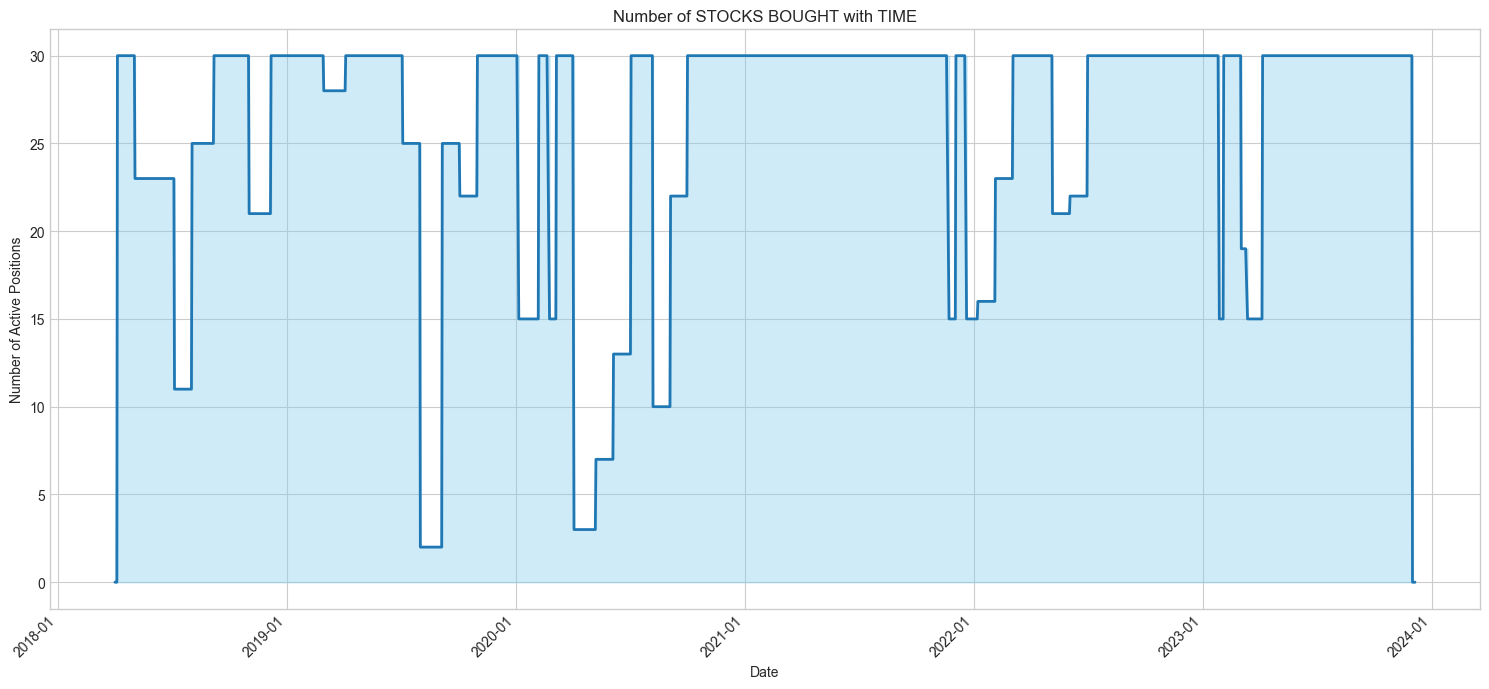

Percentage of CAPITAL INVESTED with TIME


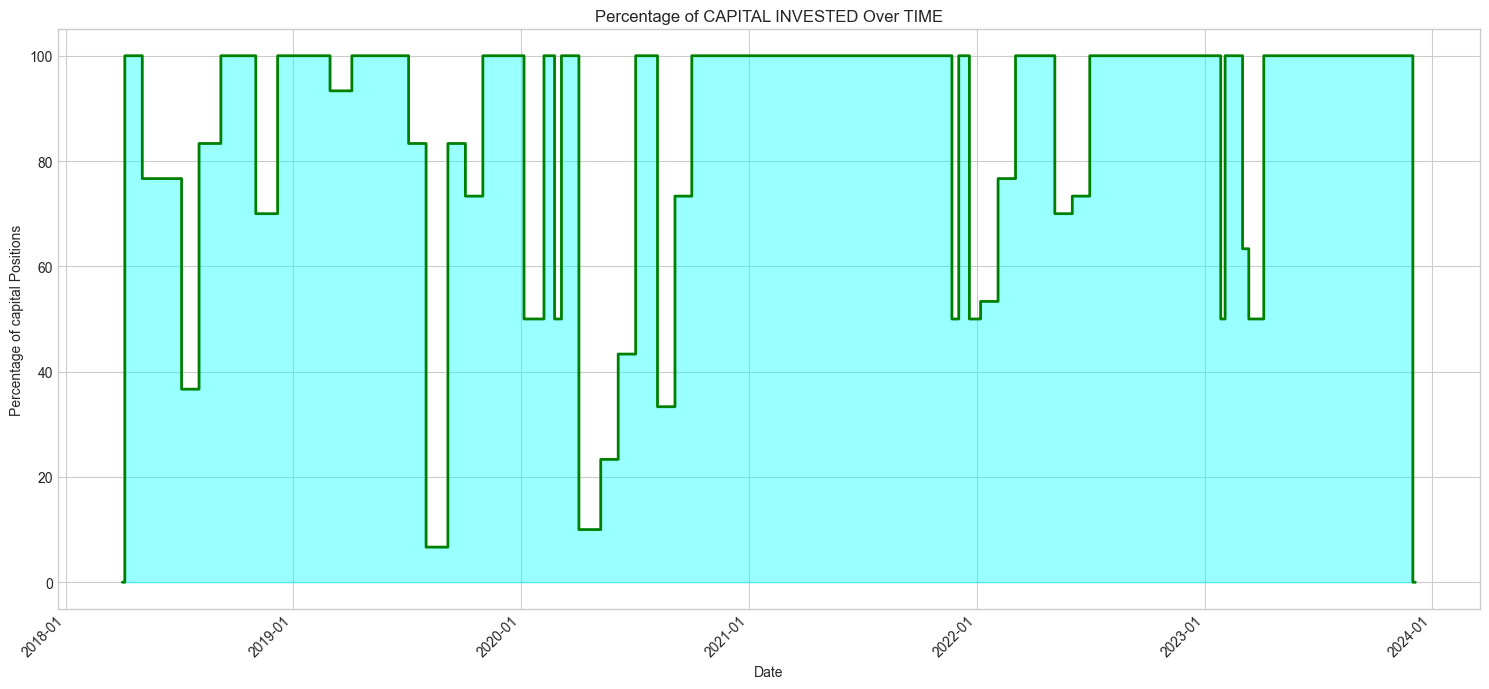

In [35]:

weights_df = pd.read_csv('auxilary/backtester_weights.csv', index_col=0, parse_dates=True)
print("---------------Successfully loaded 'results/signals.csv'---------------")

print("Number of STOCKS BOUGHT with TIME")
weights_df=weights_df.ffill()
invested_stocks_count = (weights_df > 0).sum(axis=1)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
invested_stocks_count.plot(
    ax=ax,
    title='Number of STOCKS BOUGHT with TIME',
    xlabel='Date',
    ylabel='Number of Active Positions',
    lw=2
)
ax.fill_between(
        invested_stocks_count.index, 
        invested_stocks_count.values, 
        step='post', 
        color='skyblue', 
        alpha=0.4 
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()



print("Percentage of CAPITAL INVESTED with TIME")
weights_df = pd.read_csv('auxilary/backtester_weights.csv', index_col=0, parse_dates=True)
weights_df=weights_df*100
weights_df=weights_df.ffill()
invested_stocks_count = weights_df.sum(axis=1)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
invested_stocks_count.plot(
    ax=ax,
    title='Percentage of CAPITAL INVESTED Over TIME',
    xlabel='Date',
    ylabel='Percentage of capital Positions',
    lw=2,
    drawstyle='steps-post',
    color='green'
)
ax.fill_between(
        invested_stocks_count.index, 
        invested_stocks_count.values, 
        step='post', 
        color='cyan', 
        alpha=0.4 
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


In [17]:
def backtest_looptest(start_date, end_date,z_mean, universe_name, frequency="monthly", 
             initial_capital=100000, number_stocks_active=100, 
             zscore_threshold=0.0,period=48, risk_free_rate=0.04):
    
    # --- 1) Read your daily trading_signals.csv to get the full daily index ---
    # Read with the first column as the index and parse it as dates
    dates = pd.read_csv("nifty500_daily_ohlcv_clipped.csv",index_col=0,parse_dates=True)
    signals_df=pd.read_csv("cache/backtester_weights_cache.csv",index_col=0,parse_dates=True)

    # This is your universe of all trading days
    daily_index = dates.index
    daily_index =daily_index[1:]
    daily_index=pd.DatetimeIndex(daily_index)
    #signals_df = pd.read_csv("cache/backtester_weights_cache.csv",index_col=0,parse_dates=True)
    #daily_index = signals_df.index
    # --- 2) Pre-allocate a weights DataFrame with NaNs on that daily index ---
    weights_df = pd.DataFrame(
        data    = np.nan,
        index   = daily_index,
        columns = signals_df.columns  # all tickers in that file
    )

    z_score_period = period
    z_score_file = 'cache/z_scores_mean_cache.csv' if z_mean else 'cache/z_scores_cache.csv'
    
    # Load the universe from the CSV file
    universe_file = universe_files.get(universe_name)
    if not universe_file:
        raise ValueError(f"Invalid universe name: {universe_name}. Choose from {list(universe_files.keys())}")
    
    universe_df = pd.read_csv(universe_file)
    universe = universe_df.iloc[:, 2].tolist()  # Assuming stock symbols are in the third column
    
    # Load stock prices and z-scores
    stock_prices = pd.read_csv('split_ohlcv_data/all_close.csv', parse_dates=['Date'], index_col='Date')
    z_scores = pd.read_csv(z_score_file, parse_dates=['Date'], index_col='Date')

    # Filter valid stocks
    valid_universe = [stock+".NS" for stock in universe if stock+".NS" in stock_prices.columns]

    # Filter data based on date range
    stock_prices = stock_prices.loc[start_date:end_date, valid_universe]
    z_scores = z_scores.loc[start_date:end_date, valid_universe]
    #----------------------------------
    portfolio_value = initial_capital
    portfolio_history = []
    dates = z_scores.index

    rebalancing_dates = get_rebalancing_dates()
    rebalancing_dates = pd.DatetimeIndex(rebalancing_dates)
    
    # rebalancing_dates = rebalancing_dates[rebalancing_dates >= dates[z_score_period]]
    # rebalancing_dates = pd.DatetimeIndex(rebalancing_dates)

    rebalancing_dates = rebalancing_dates[rebalancing_dates >= '2018-04-02']
    rebalancing_dates = pd.DatetimeIndex(rebalancing_dates)
    
    portfolio_history.append({'date': rebalancing_dates[0], 'value': portfolio_value})

    # Load mapping once outside the loop
    date_mapping = pd.read_csv("date_mapping.csv", parse_dates=["week_start", "week_end", "rebalancing_date"])

    for i, current_date in enumerate(rebalancing_dates[:-1]):
        next_date = rebalancing_dates[i + 1]
        
        current_week_start = date_mapping.loc[date_mapping["rebalancing_date"] == current_date, "week_start"].iloc[0]
        current_week_end = date_mapping.loc[date_mapping["rebalancing_date"] == current_date, "week_end"].iloc[0]
        previous_distinct_week_start = date_mapping.loc[(date_mapping["rebalancing_date"] < current_date) &(date_mapping["week_start"] != current_week_start),"week_start"].iloc[-1]
        if(current_date==current_week_end) :
            z_date= current_week_start
        
        else :
            z_date= previous_distinct_week_start
        
        current_z_scores = z_scores.loc[z_date].dropna()
        
        # Select stocks above the threshold
        top_stocks = current_z_scores[current_z_scores >= zscore_threshold].nlargest(number_stocks_active).index
        
        top_set = set(top_stocks)
        record_monthly_weights(weights_df, current_date,next_date, top_set,number_stocks_active)

    # Log the last rebalancing selection (no return calculated)
    rebalancing_dates.normalize()
    weights_df.to_csv("cache/backtester_weights_cache.csv", index_label="Date")
    # return pd.DataFrame(portfolio_history)

In [18]:
def z_score_looptest(start_date, end_date, universe, rolling_threshold, period, mean_period):
    # --- 1. Load Data ---
    if universe == 'Small Cap':
        symbols_df = pd.read_csv('data/niftysmallcap100/ind_niftysmallcap100list.csv')
    elif universe == 'Large Cap':
        symbols_df = pd.read_csv('data/nifty50/ind_nifty50list.csv')
    elif universe == 'Mid Cap':
        symbols_df = pd.read_csv('data/niftymidcap100/ind_niftymidcap100list.csv')
    elif universe == 'Micro Cap':
        symbols_df = pd.read_csv('data/niftymicrocap250/ind_niftymicrocap250_list.csv')
    elif universe == 'All Cap':
        symbols_df = pd.read_csv('data/nifty500/ind_nifty500list.csv')
    
    symbols = symbols_df['Symbol'].tolist()
    
    # Load weekly closing prices
    weekly_close = pd.read_csv('split_ohlcv_data/all_close.csv', parse_dates=['Date'], index_col='Date')
    
    # Ensure only available symbols are selected
    available_symbols = [symbol + ".NS" for symbol in symbols if symbol + ".NS" in weekly_close.columns]
    if not available_symbols:
        raise ValueError("None of the selected symbols are present in weekly_close.csv")

    # Slice data according to start and end date
    weekly_close = weekly_close.loc[start_date:end_date, available_symbols]
    
    # --- 2. Perform Calculations on the Entire DataFrame ---
    weekly_returns = np.log(weekly_close / weekly_close.shift(1))

    rolling_mean = weekly_returns.rolling(window=period).mean()
    rolling_std = weekly_returns.rolling(window=period).std()

    z_scores = np.where(
        rolling_mean >= rolling_threshold,  # Condition
        ((weekly_returns - rolling_mean) / rolling_std), # Value if True
        ((weekly_returns - rolling_mean) / rolling_std)
    )
    
    # Create the Z-Scores DataFrame
    z_scores_df = pd.DataFrame(z_scores, index=weekly_returns.index, columns=weekly_returns.columns)
    z_scores_df = z_scores_df.fillna(0)
    # Compute rolling mean of period 'mean_period' for Z-scores
    z_scores_mean_df = z_scores_df.rolling(window=mean_period).mean().fillna(-10)

    z_scores_df.to_csv('cache/z_scores_cache.csv')
    # Save the rolling mean Z-scores to CSV
    z_scores_mean_df.to_csv('cache/z_scores_mean_cache.csv')
    return z_scores_df, z_scores_mean_df

In [19]:
import pandas as pd
import numpy as np
import vectorbt as vbt
from IPython.display import display

# --- 1. Load Data and Define Parameters ---
# (Your data loading and parameter lists remain the same)
data = pd.read_csv(
    'nifty500_daily_ohlcv_clipped.csv',
    index_col=0, header=[0, 1], parse_dates=True
)
data = data.sort_index()
INITIAL_CAPITAL = 100000
TRADING_START_DATE = '2017-01-01'

# ... (parameter lists) ...
rolling_period_list = [12,16,20,24,28,32,36,40,44,48,52,56,60,64]
mean_period_list = [12,16,20,24,28,32,36,40,44,48,52,56,60,64]
rolling_threshold_list = [0]

all_results = []
close_prices_full = data.xs('Close', level=1, axis=1)
weekly_returns = np.log(close_prices_full / close_prices_full.shift(1))
count=0
tot=len(rolling_period_list)*len(mean_period_list)*len(rolling_threshold_list)
print("\n---------------------------- Starting Parameter Optimization Grid Search ----------------------------\n----------------------------- Results will be stored in all_results.csv -----------------------------")

# --- 2. Main Loop ---
for rolling_period in rolling_period_list:
    for mean_period in mean_period_list:
        for rolling_threshold in rolling_threshold_list:
            count+=1
            print(f"{count}/{tot}---------Running for:\t roll={rolling_period},\t mean={mean_period},\t roll_thr={rolling_threshold}\t\t-----------")

            # --- A. Generate Signals and weights ---
            z_score_looptest(START_DATE, END_DATE, UNIVERSE_NAME, rolling_threshold, rolling_period, mean_period)
            backtest_looptest(START_DATE, END_DATE, Z_MEAN, UNIVERSE_NAME, FREQUENCY,INITIAL_CAPITAL, NUM_STOCKS_ACTIVE, rolling_threshold, ZSCORE_PERIOD)

            fresh_strategy = Strategy_looptest()
            
            backtester = Backtester(data, INITIAL_CAPITAL,TRADING_START_DATE)
            backtester.run_looptest()
            pf = backtester.vectorbt_run_looptest(rolling_period,mean_period,rolling_threshold)

            all_results.append(pf)
            all_results_df=pd.DataFrame(all_results)
            all_results_df.to_csv('all_results.csv')
            
# --- The rest of your script for displaying results ---
if all_results:
    results_df = pd.DataFrame(all_results)
    final_3d_df = results_df.set_index(['rolling_period', 'mean_period', 'rolling_threshold'])
    print("\n------------------------------------- Final 3D Results DataFrame -------------------------------------")
    display(final_3d_df.round(4))



---------------------------- Starting Parameter Optimization Grid Search ----------------------------
----------------------------- Results will be stored in all_results.csv -----------------------------
1/196---------Running for:	 roll=12,	 mean=12,	 roll_thr=0		-----------


 28%|██▊       | 389/1403 [00:06<00:16, 60.44it/s]


KeyboardInterrupt: 